In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from IPython.core.display import display, HTML

display(HTML("""
<style>
    @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono:wght@400;500;600;700&display=swap');
    * {
        font-family: 'JetBrains Mono', monospace !important;
        font-size: 17px !important;
    }
</style>
"""))

In [ ]:
from IPython.core.display import display, HTML

display(HTML("""
<style>
    @import url('https://cdnjs.cloudflare.com/ajax/libs/hack-font/3.003/web/hack.css');
    * {
        font-family: 'Hack', monospace !important;
    }
</style>
"""))

### Enhanced MRI Brain Tumor Classification
- In this project, we focus on creating a machine learning model that reliably identifies normal and various tumor-affected brain images, such as pituitary, meningioma, and glioma tumors. Understanding the necessity for accurate diagnoses in regions with limited medical imaging quality, our objective extends to ensuring the model's high performance on low-quality images, thus promoting excellent generalization and utility in diverse healthcare settings.

### 🎯 Project Objectives
- **Dataset Exploration**: Examine class balances and image dimensions to understand dataset characteristics.
- **Training on Degraded Image Quality**: Enhance model robustness to low-quality images with controlled degradation techniques.
- **Transfer Learning for Accuracy**: Use ResNet50V2 pre-trained model for high accuracy without overfitting, despite a limited dataset.
- **Focused Model Training and Fine-Tuning**: Strategically train and fine-tune the model for reliable MRI image classification.
- **Validation Performance Validation**: Evaluate the model thoroughly on a validation set to ensure dependable performance.
- **Model Deployment Readiness**: Prepare the model for real-world application by saving and archiving for deployment.

Table of Contents
- Step 1 | Setup and Initialization
- Step 2 | Dataset Analysis
- Step 3 | Dataset Preparation
    - Step 3.1 | Centralizing Dataset Information
    - Step 3.2 | Data Splitting into Training & Validation Sets
    - Step 3.3 | Augmentation of Dataset with Artificially Degraded Images
    - Step 3.4 | Establishing Data Generators for Model Input
- Step 4 | Model Architecture Development
- Step 5 | Full Model Training and Fine-Tuning
- Step 6 | Model Performance Assessment
    - Step 6.1 | Visualizing the Learning Curves
    - Step 6.2 | Performance Metrics Assessment
- Step 7 | Saving the Model for Deployment

# Step 1 | Setup and Initialization

- First of all, let's import all the necessary libraries needed for our project:

In [2]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import cv2
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
# preprocess_input ==> It is a function that changes pixel values of images to a format that ResNetV2 expects (because that’s how it was trained).
# ResNetV2 wants images with pixel values between -1 and 1 (not 0 to 255)
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

In [3]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')

## Step 2 | Dataset Analysis

Now, I am transferring our MRI image dataset from Kaggle's dataset location to our current working directory to start analyzing and processing it:

In [4]:
# Copying the dataset from the Kaggle input folder to the working directory
!cp -r /kaggle/input/mri-images/Data /kaggle/working/
# -r: Means recursive: copy the entire folder and all of its contents (subfolders and files).

In [1]:
!rm -r /kaggle/working/Data

rm: cannot remove '/kaggle/working/Data': No such file or directory


Then, I am going to do initial analysis to examine the distribution of image classes within the dataset:

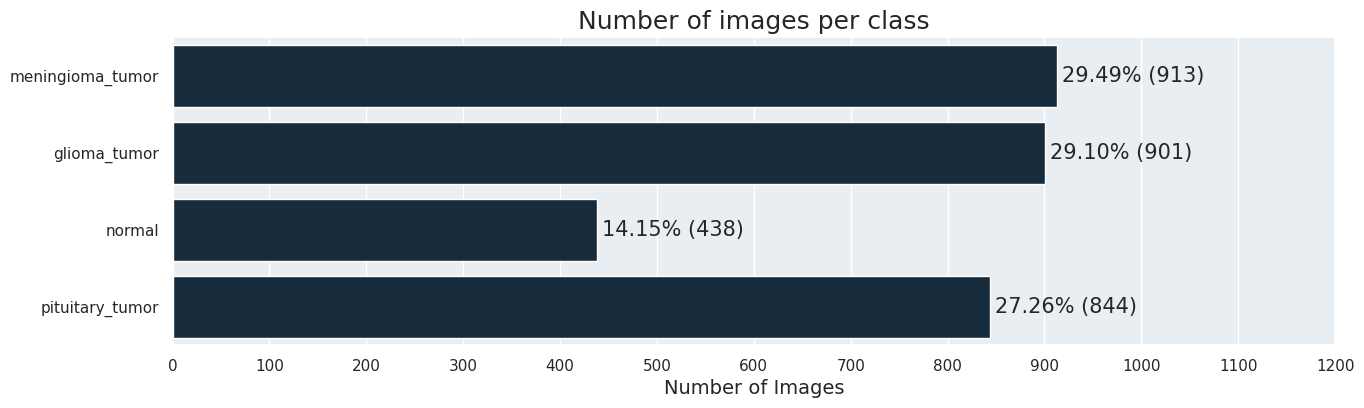

In [5]:
# The Directory where the image folders are located
base_dir = '/kaggle/working/Data' # kol el data folders ba2t mawgooda gwa el path dah

# Obtain class names from the folder names in base_dir
classes = [folder_name for folder_name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder_name))]
# os.listdir(base_dir) deeh ma3naha en ana 3awz ageeb kol el files w el folders ely mawgooda gwa el base_dir
# if os.path.isdir(os.path.join(base_dir, folder_name) ==> deeh ma3naha en ana bashoof hal el 7aga ely mawgooda gwa el Data folder dah folder wla msh folder
# classes is a list containing the names of all the folders inside the Data directory

# Counting the number of images in each folder
counts = [] # deeh list 7a7ot feeha 3add el images ely mawgooda gwa kol class mawgood 3andy
for class_name in classes: # hena ana 7a3ml loop 3la kol folder men el folders ely mawgooda gwa el Data folder
    folder_path = os.path.join(base_dir, class_name) # hena ana 7ageeb el path beta3 el folder
    counts.append(len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])) # hena ana 7adeef 3add el files aw 3add el images ely mawgooda gwa kol folder
# os.listdir(folder_path) hena ana 7ageeb kol el files aw kol el images ely mawgooda gwa el folder


# Calculating the total number of images
total_count = sum(counts) # get the total number of images in all the classes 


# Calculating the percentages
percentages = [(count / total_count) * 100 for count in counts]
# percentages deeh list feeha el percentage beta3t kol el images ely mawgooda gwa kol folder


# Set the figure size
plt.figure(figsize=(15, 4))

# Create a horizontal bar plot
ax = sns.barplot(y=classes, x=counts, orient='h', color='#102C42')

# Set x-axis interval (adjust as needed)
ax.set_xticks(range(0, max(counts) + 1, 1000))

# Annotate each bar with the count and percentage
for i, p in enumerate(ax.patches): # hena ana 7a3ml loop 3la kol bar mawgood gwa el plot
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{:1.2f}% ({})'.format(percentages[i], counts[i]),
            va="center", fontsize=15)

# Set the x-label for the plot
plt.xlabel('Number of Images', fontsize=14)

# Set x-axis interval
ax.set_xticks(range(0, max(counts) + 300, 100))

# Set the title and show the plot
plt.title("Number of images per class", fontsize=18)
plt.show()

## 📊 Class Distribution Insights
- The **'normal'** class, being the least represented in the dataset, could be critical in ensuring balanced model performance. As we proceed, special attention may be needed in model training to mitigate any potential bias towards the more prevalent classes.

Then, I will proceed to analyze the dimensions of the images:

In [6]:
# Lists to store heights and widths of all images
heights = [] # list to add the heights for all the images 
widths = [] # list to add the widths for all the images 

# Initialize sets to store unique dimensions
unique_dims = set() # to store only unique dimensions

# Loop over each class and their respective images
for class_name in classes: # loop through all the classes 
    folder_path = os.path.join(base_dir, class_name) # get the path of the class
    for filename in os.listdir(folder_path): # get all the images inside the folder
        img_path = os.path.join(folder_path, filename) # get the path of the image inside the folder
        img = cv2.imread(img_path) # read the image from the path
        if img is not None: # if there is an Image
            # Add the dimensions (height, width, channels) to the set
            unique_dims.add((img.shape[0], img.shape[1])) # add the dimensions of the image in the set
            
            # Append heights and widths for statistical calculations
            heights.append(img.shape[0])
            widths.append(img.shape[1])

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else: # if all the images dont have the same dimensions
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
    print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

All images have the same dimensions: (256, 256)


## 🔍 Image Dimension Analysis
- Uniformity in image dimensions (256x256) across the dataset simplifies preprocessing and ensures consistent input shape for model training, enabling more streamlined augmentation and scaling procedures.

Next, lets take a look at the images across all four classes to get a visual feel for the data we're working with:

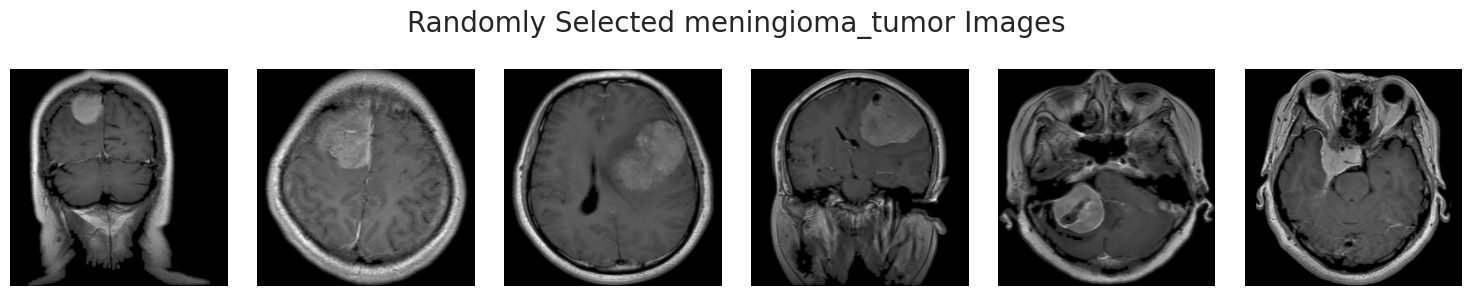

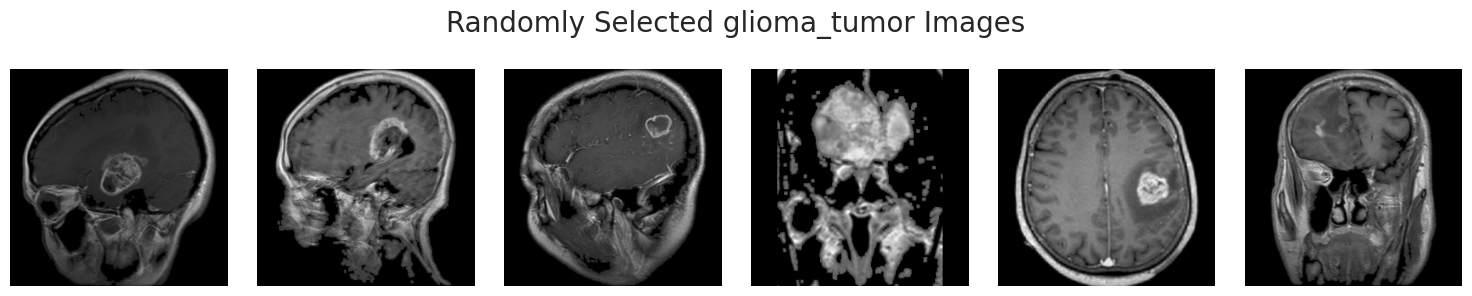

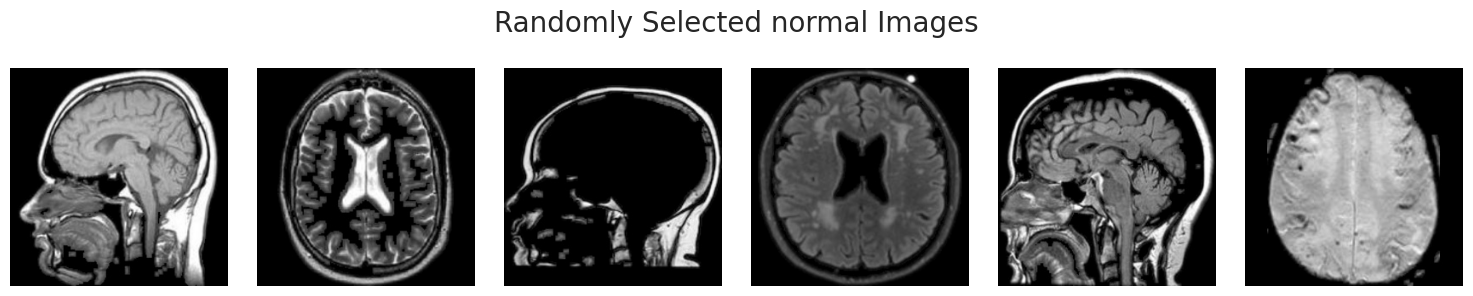

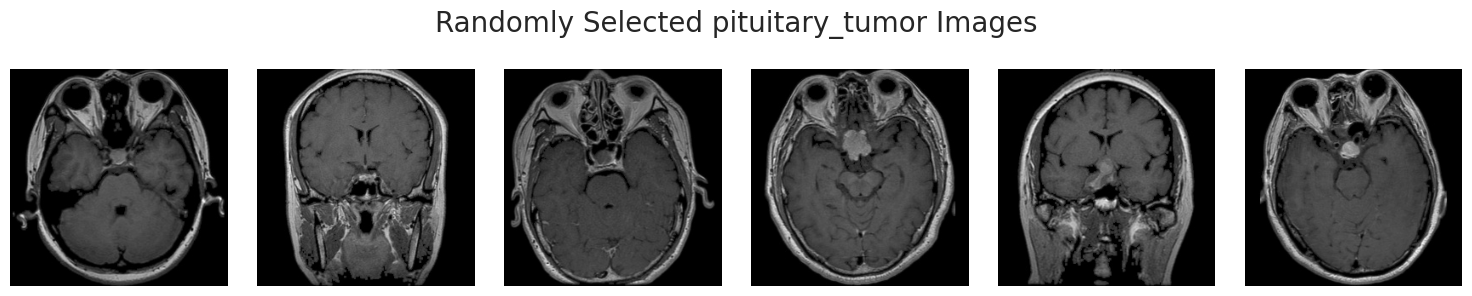

In [7]:
# Function to plot images
def plot_images(images, title): # take the Images you want to plot and the title
    plt.figure(figsize=(15, 3)) # set the figure size
    for i, img_path in enumerate(images): # loop through the images 
        plt.subplot(1, 6, i+1)  # 1x6 subplot
        img = cv2.imread(img_path) # read the image from the path
        # Convert the BGR image to RGB Image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img) # show me the Image
        plt.axis('off') # dont show the axis
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Setting the random seed for reproducibility
np.random.seed(42) # to get the same random Images each time we run the cell 

# Loop over each class and plot random images
for class_name in classes: # loop through each folder
    folder_path = os.path.join(base_dir, class_name) # get the path of the folder
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)] # get all the images in the folder
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly without replacment which means no repeated images are allowed
    plot_images(random_images, f"Randomly Selected {class_name} Images") # plot the random selected Images 

## 🖼️ Visual Sample of MRI Scans
- A glimpse into the dataset reveals a grayscale palette, typical of MRI scans, providing detailed insights into the different classes of brain images.

## Step 3 | Dataset Preparation

Step 3.1 | Centralizing Dataset Information

- First of all, I am going to centralize the dataset's information into a DataFrame. This makes it easier to manage and process the data in the subsequent steps:

In [8]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop over each class and append the image file paths with their respective labels to the data list
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name) # get the path of the folder
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath             label
0   /kaggle/working/Data/meningioma_tumor/M_67.jpg  meningioma_tumor
1  /kaggle/working/Data/meningioma_tumor/M_724.jpg  meningioma_tumor
2   /kaggle/working/Data/meningioma_tumor/M_31.jpg  meningioma_tumor
3  /kaggle/working/Data/meningioma_tumor/M_889.jpg  meningioma_tumor
4  /kaggle/working/Data/meningioma_tumor/M_849.jpg  meningioma_tumor

In [9]:
print("The total number of Images:", df.shape[0])

The total number of Images: 3096


In [10]:
# Deleting unnecessary variables to free up memory
del data, all_images

### Step 3.2 | Data Splitting into Training & Validation Sets

Then, I am going to split our dataset into train and validation sets, ensuring a balanced class distribution with stratification and mixing the images for randomness using shuffling:

In [11]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
# df this is the dataframe we want to split because it contains all the images we have
# test_size=0.2 this means that we will test the model on 20% of the data and we will Train the model on 80% of the data
# startify=df["label"] this means that ratio between the classes in the train_df and the ratio between the classes in the val_df will have the same ratio between classes in df['label']
# random_state=42 to get the same split each time we run the cell

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (2476, 2)
Validation data shape: (620, 2)


In [12]:
# Display the first few rows of the train DataFrame
train_df.head(10)

filepath             label
626   /kaggle/working/Data/meningioma_tumor/M_676.jpg  meningioma_tumor
311   /kaggle/working/Data/meningioma_tumor/M_590.jpg  meningioma_tumor
1741      /kaggle/working/Data/glioma_tumor/G_734.jpg      glioma_tumor
627   /kaggle/working/Data/meningioma_tumor/M_179.jpg  meningioma_tumor
3034   /kaggle/working/Data/pituitary_tumor/P_243.jpg   pituitary_tumor
1458      /kaggle/working/Data/glioma_tumor/G_495.jpg      glioma_tumor
1609      /kaggle/working/Data/glioma_tumor/G_417.jpg      glioma_tumor
1394      /kaggle/working/Data/glioma_tumor/G_353.jpg      glioma_tumor
132   /kaggle/working/Data/meningioma_tumor/M_795.jpg  meningioma_tumor
2198             /kaggle/working/Data/normal/N_72.jpg            normal

In [13]:
# Display the first few rows of the validation DataFrame
val_df.head(10)

filepath             label
2788   /kaggle/working/Data/pituitary_tumor/P_654.jpg   pituitary_tumor
595   /kaggle/working/Data/meningioma_tumor/M_637.jpg  meningioma_tumor
39    /kaggle/working/Data/meningioma_tumor/M_510.jpg  meningioma_tumor
3093   /kaggle/working/Data/pituitary_tumor/P_777.jpg   pituitary_tumor
1186      /kaggle/working/Data/glioma_tumor/G_564.jpg      glioma_tumor
998       /kaggle/working/Data/glioma_tumor/G_243.jpg      glioma_tumor
110   /kaggle/working/Data/meningioma_tumor/M_499.jpg  meningioma_tumor
281   /kaggle/working/Data/meningioma_tumor/M_723.jpg  meningioma_tumor
2803   /kaggle/working/Data/pituitary_tumor/P_362.jpg   pituitary_tumor
142   /kaggle/working/Data/meningioma_tumor/M_764.jpg  meningioma_tumor

### Step 3.3 | Augmentation of Dataset with Artificially Degraded Images

🛠️ Preparing for Low-Quality Image Analysis
Considering our deep learning project on brain tumor MRI may be used in areas with low-quality imaging resources, I aim to ensure our model performs accurately with such images. To simulate lower-quality MRIs, I'll employ three techniques:

- **`1️⃣ Adding Noise`**: To replicate common imaging artifacts, I'll introduce variations like Gaussian noise noise.
- **`2️⃣ Applying Blur`**: Gaussian or motion blur will be used to mimic the blurring effect caused by patient movement or imaging hardware constraints.
- **`3️⃣ Downsampling`**: I'll reduce the image resolution to represent the capabilities of less advanced MRI machinery typically found in under-resourced settings.

Moving forward, I'll apply above techniques to our image dataset, targeting both training and testing sets separately. This step is key to understanding how our model performs on degraded images, simulating real-world scenarios where image quality varies. Crucially, we're doing these modifications after splitting the data into training and testing sets. This approach prevents **data leakage**, ensuring that our model's performance evaluation is genuine and not influenced by having seen similar images during training. It's about making sure the model truly learns and generalizes, rather than just memorizing.

📉 Setting the Degree of Image Quality Reduction
To prepare our model for the variable quality of medical imaging in less equipped regions, specific adjustments will be made to our images:

- **`1️⃣ Adding Noise`**: The amount of noise added should be noticeable but not so overwhelming that the key features of the image are obscured. For MRI images, a small to moderate amount of Gaussian noise is often realistic. I will start with a Gaussian noise with a mean of 0 and a small standard deviation (like 0.01 to 0.05 of the pixel value range) and adjust based on the results.
- **`2️⃣ Blurring`**: For blurring, a Gaussian blur with a small kernel size (e.g., 3x3 or 5x5) can simulate slight focus issues or patient movement. The degree of blur should be enough to reduce sharpness without completely erasing critical details.
- **`3️⃣ Downsampling`**: When downsampling, reducing the image resolution by a factor (e.g., to half or one-third of the original dimensions) and then resizing back to the original size can simulate lower resolution. The key is to degrade the image's clarity while retaining its overall structure.

In [14]:
def add_gaussian_noise(image, mean=0, std=0.05):
    # mean=0: Noise is centered around 0 (no bias).
    # std=0.05: Controls how strong the noise is (higher = noisier).
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape) # generate random numbers from the Normal distrubution, image.shape this means that the size of the noise is the same size of the Image
    noisy_image = image + gauss # add the noise to the Image
    noisy_image = np.clip(noisy_image, 0, 255) # this ensures that the pixel values should be between 0(black) and 255(white)
    return noisy_image
    # The function returns the noisy version of the image, which can be used for training a model (to make it robust to noisy inputs).

In [15]:
def apply_blur(image, kernel_size=5):
    # image is the image we want to make the blurring
    # as the size of the kernel increase the blurring will increase
    # the kernel size must be an odd number
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [16]:
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100) # decrease the width of the image to the half
    height = int(image.shape[0] * scale_percent / 100) # decrease the height of the image to the half
    dim = (width, height) # this is the new dimensions after downsampling
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA) # resize the image to the new dimensions and interpolation=cv2.INTER_AREA is useful for shrinking the image
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)
    # return the original size of the Image and interpolation=cv2.INTER_LINEAR is used for enlarging the image

Before applying modifications, lets find the total number of images:

In [17]:
def count_images(dataframe):
    """ Function to count the total number of images in a DataFrame """
    return dataframe.shape[0]

In [18]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 2476
Total number of validation images: 620


To address common image quality challenges in less equipped regions, we'll enhance our dataset. I'll randomly apply one or two or all the three image quality reduction techniques to each image randomly, then incorporate these altered images back into our original dataset. This approach effectively doubles the number of images, enriching our dataset with a range of qualities that mirror real-life conditions:

In [19]:
def augment_images(dataframe, base_dir): # we will pass the train_df or the valid_df
    modified_data = []
    
    for _, row in dataframe.iterrows(): # get the index of the row and the row iteself which contains the filepath and the label
        img_path = row['filepath'] # get the image_path of the image
        label = row['label'] # get the label of the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # read the image from the image_path
        # img is a list containing all the image after we read them

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices))) # select random choices

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [20]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df, base_dir)
val_df = augment_images(val_df, base_dir)

[ WARN:0@220.818] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Lets count the number of images in our dataset again after applying the modifications:

In [21]:
# Count and print the number of images in the training and validation sets after the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 4952
Total number of validation images: 1240


Now, let's take a look at a random selection of images from each class post-transformation. It's crucial to check that the important tumor characteristics remain visible, ensuring our model can still accurately detect and learn from these varied conditions:

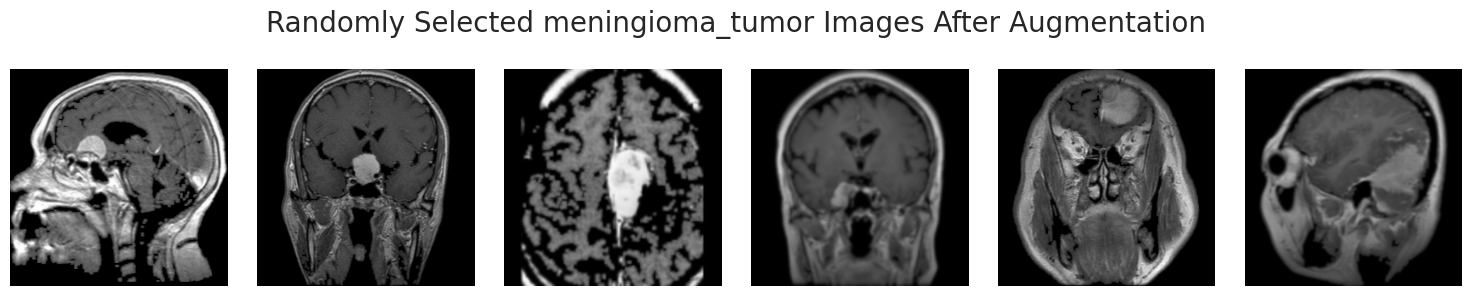

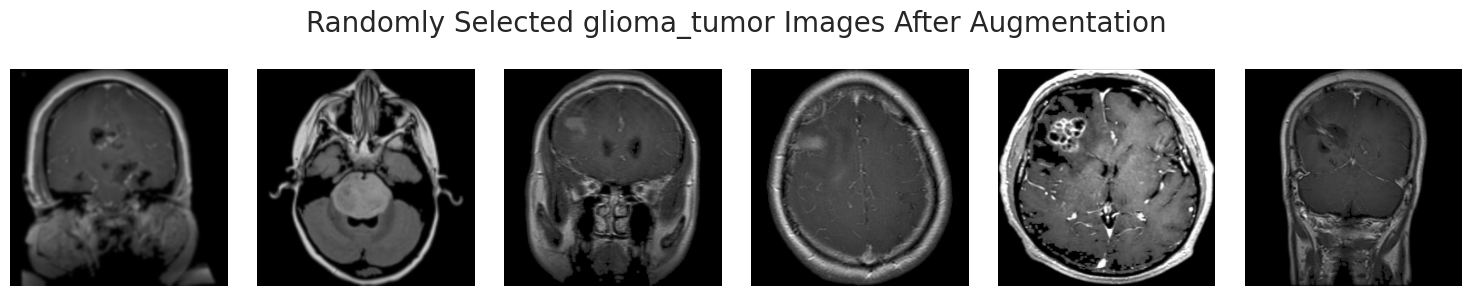

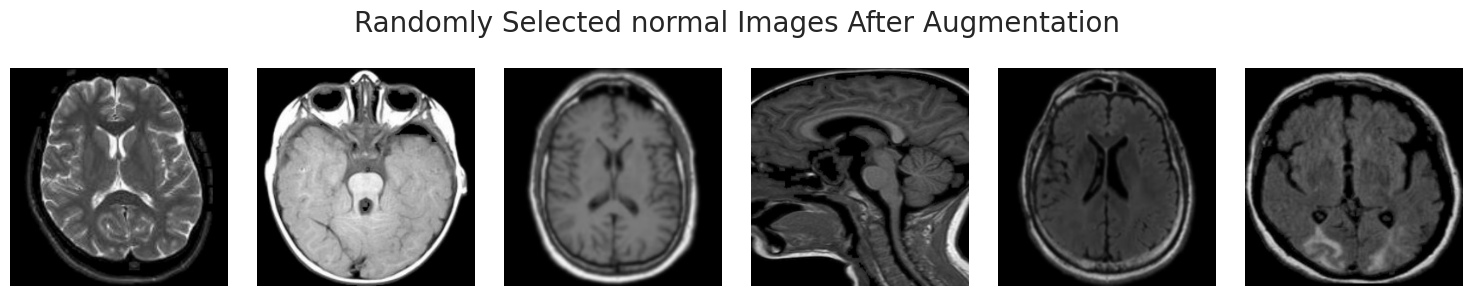

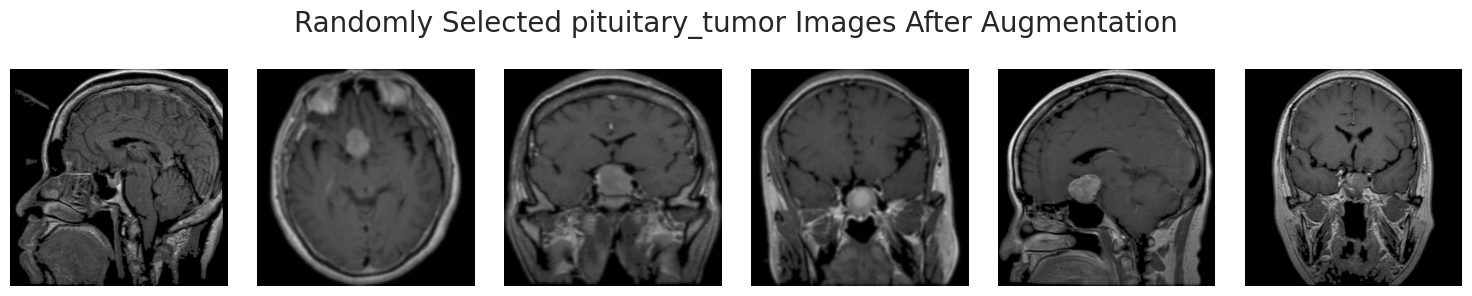

In [22]:
# Loop over each class and plot random images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

🖼️ Visual Assessment Post-Transformation
- Observing the randomly selected images post-transformation, it's evident that we've successfully introduced variations in quality, simulating real-world degradation.

## Step 3.4 | Establishing Data Generators for Model Input

Finally, in the dataset preparation phase, I am crafting a streamlined pipeline using Keras's **ImageDataGenerator**. This setup is designed to dynamically preprocess and augment images **on-the-fly** during training, which is a memory-efficient approach. For our MRI images, we're incorporating specific augmentations to mimic realistic variations: slight rotations to represent patient positioning, small shifts in width and height for different scan angles, zooming to simulate scan focus variations, and horizontal flips when image laterality isn't a factor. These carefully chosen augmentations ensure the preservation of critical medical information while enhancing the model's ability to generalize. The function is tailored to preprocess images optimally for the neural network we're training.

In [23]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):
    """
    Creates and returns training and validation data generators with optional preprocessing.
    
    Parameters:
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - preprocessing_function (function, optional): Preprocessing function specific to a model. Defaults to None.
    - batch_size (int, optional): Number of images per batch for the generators. Defaults to 32.
    - image_dimensions (tuple, optional): Dimensions to which the images will be resized (height, width). Defaults to (224, 224).
    
    Returns:
    - train_generator (ImageDataGenerator): Generator for training data.
    - val_generator (ImageDataGenerator): Generator for validation data.
    
    Notes:
    - The validation generator does not use any augmentations.
    - If provided, the preprocessing function is applied to both generators.
    """

    # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
        preprocessing_function=preprocessing_function
    )
# this means that the train_datagen will rescale all the images in the loaded Training batch to make the pixel values in each image between -1 and 1 and this what preprocess_input function do and each image in the batch will get a random combination from the augmentation techniques we have in the train_datagen
# Each image in the batch gets a random combination of those augmentations.

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )
# this means that the val_datagen will rescale all the Images in the loaded validation batch to make the pixel values between -1 and 1 and this is what preprocess_input function do

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col="filepath",                   # Column with paths to image files
        y_col="label",                      # Column with image labels
        target_size=image_dimensions,       # Resize all images to size of 224x224 
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,                            # Seed for random number generator to ensure reproducibility
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )
# this means that the train_generator will shuffle all the Training Images and then load a batch of 32 images from the filepath column with their labels in the label column and then we will resize each image to be (224, 224)
# class_mode='categorical' 3shan ana hena ba3ml multi-class classification and class_mode='categorical' will make the labels one-hot-encoded
# so this means that the train_generator will load a batch of 32 Training images with their one-hot-encoded labels

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",                       
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,
        shuffle=False                       # Shuffling not necessary for validation data
    )
# this means that the val_generator will load a batch of 32 validation images from the val_df dataframe and the validation images is in the column called filepath and the labels are found in the label column and then we resize all the images in the batch to be (224, 224)
# class_mode='categorical' 3shan ana hena ba3ml multi-class classification and class_mode='categorical' means that we will load the Images One-Hot-Encoded
# so this means that val_generator will load a batch of 32 validation images with their One-Hot-Encoded labels
    
    # Return the training and validation generators
    return train_generator, val_generator

Let's call the `create_data_generators` function and then check the shape of the first image in a batch of images:

In [24]:
# Create the data generators
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)

# use the train_generator to Fetch a batch of training images and labels 
batch_images, batch_labels = next(train_generator)
# batch_images the images from the batch.
# batch_labels the labels from the batch.

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)
# batch_images[0].shape ==> this will get the shape of the first image in the batch

# Found 4952 validated image filenames belonging to 4 classes ==> this means that there are 4952 Training Images 
# Found 1240 validated image filenames belonging to 4 classes ==> this means that there are 1240 validation Images 

Found 4952 validated image filenames belonging to 4 classes.
Found 1240 validated image filenames belonging to 4 classes.
Shape of the first image in the batch: (224, 224, 3)


In [25]:
# Retrieve the class names
class_indices = train_generator.class_indices

# Sorting the class indices to get the list of class names in the correct order
class_names = sorted(class_indices, key=class_indices.get)
class_names 

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

## 🧠 MRI Image Channel Adaptation for Pre-trained Models
- Our MRI images are naturally grayscale, but we're intentionally reading them as 3-channel images. This aligns with the architecture of pre-trained models developed on **ImageNet**, which features color images. Adapting our grayscale images to this format is crucial for leveraging the full potential of these advanced models and achieving benchmark performance.

## Step 4 | Model Architecture Development

👩‍⚕️ Choosing the Right Model for Medical Image Classification
- In our medical project, which aims to accurately classify MRI brain images into normal or one of several tumor types, selecting a highly accurate model is critical because we're dealing with human health. While real-time processing isn't required, accuracy is paramount. Given that we have a modestly-sized dataset of 6,192 images, fully training a complex model from scratch poses a risk of overfitting. To circumvent this, I am employing transfer learning, starting with the ResNet50V2 model pre-trained on ImageNet. I will customize this model by replacing the top layer with our own classifier designed for a 4-class problem, harnessing the pre-trained network's robust feature extraction capabilities without the overfitting concern:

In [26]:
# load the pretrained RESNET50V2 model without the top-layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))
# input_shape=(224,224,3) this means that the shape of the Input image to the resnet50v2 model is 224 height and 224 width and 3 color channels

# include_top=False ==> this means we dont want to load the fully connected layers which is in the ResNet50V2 model because we want to add our custom dense or fully connected layers for our task
    # The "top" part of ResNet50V2 is the fully connected (Dense) layers used for ImageNet classification (1000 classes).
    # Setting include_top=False removes these layers, leaving only the convolutional base (feature extractor).
    # We can then add our own layers to adapt the model for our task (e.g., brain tumor classification with 4 classes).

# weights='imagenet' ==> Loads pre-trained weights learned from ImageNet (a huge dataset with 1.2M images).


# if we make freeze to the weights this means that we will not update or Train the weights in the convolutional layers in the resnet50v2 model and we will only update or Train the weights in the fully connected layers we will add
# if we don't make freeze to the weights this means that we will update or Train the weights in the convolutional layers in the resnet50v2 model and we will also update or Train the weights in the fully connected layers we will add

I0000 00:00:1753351823.091405      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753351823.092122      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
# this means that we will apply the GlobalAveragePooling2D on the output from the base_model and the shape of the output from the base_model is (7,7,2048)
# GlobalAveragePooling take the mean of every feature map we have and convert the feature vector into a single number, So each feature map becomes a single number (its mean value).
# (7,7,2048) this is the shape of the output before the fully connected layers and after the convolutional layers
# (7,7,2048) this means that we have 2048 feature maps and the shape of each feature map is 7 height and 7 width
# when we do the global average pooling we will get the average for each feature map from the 2048 feature maps we have so this means we convert (7,7,2048) into (2048, )
x = Dense(1024, activation='relu')(x) # this is a dense layer having 1024 nodes 
# the shape of the output from this dense layer is (1024, )
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
# the shape of the output after we make the dropout is (1024, )
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification
# activation='softmax' because we want to get the probability for each class 

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
# metrics=["accuracy"] ==> this means that we will focus on the accuracy in the Training and in the validation
# loss="categorical_crossentropy" ==> because we are doing multi-class classification and the labels are one-hot-encoded
# oprimizer=Adam dah el Optimizer ely ana 7ast5dmo 3shan ageeb a7san kym ll Parameters ely mawgooda 3andy w el Parameters tab3an heya el weights w el biases 
# hena ana 3awz ageeb a7san kym ll weights w el biases ely mawgooda fy el convolutional layers w el custom dense layers 3shan ana ma3mltsh freeze ll weights w el biases ely mawgooda fy el convolutional layers
# ama law ana kont 3amlt freeze yeb2a ana kont 7ageeb a7san kym ll weights w el biases ely mawgooda fy el custom fully connected layers ely ana 7adeefha ama el weights ely mawgooda fy el convolutional layers aslan mafeesh update leeha 3shan ana 7a3mlha freeze
# learning_rate=0.0001 this controls how fast do we update the Parameters

In [28]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,667,076 (97.91 MB)

 Trainable params: 25,621,636 (97.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

### 💾 Model Complexity and Fine-Tuning Strategy
- The summary of our model shows it's quite large, with nearly 25.6 million parameters. We've opted not to freeze any layers, meaning the entire model, including its feature extractor, will be fine-tuned. The classifier part, tailored to our specific task, will be trained from scratch, ensuring a comprehensive learning process that is customized for our brain MRI image dataset.

## Step 5 | Full Model Training and Fine-Tuning

Next, we are embarking on a crucial step: training and fine-tuning our entire model. This step involves using our prepared training and validation datasets to iteratively improve the model's ability to classify brain MRI images. I'll apply specific preprocessing, monitor performance, adjust learning rates, and use early stopping to prevent overfitting. Our goal is to ensure that the model learns effectively from our dataset, optimizing its accuracy for medical image classification:

In [30]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=32, num_epochs=50):
    """
    Creates and returns training and validation data generators with optional preprocessing and augmentation.
    
    Parameters:
    - model: Model, a compiled instance of a Keras model to be trained.
    - train_df: DataFrame, the training data.
    - val_df: DataFrame, the validation data.
    - preprocessing_function: function, preprocessing function to be applied to input data.
    - image_dimensions: tuple, dimensions of the images (width, height).
    - batch_size: int, number of samples per batch of computation.
    - num_epochs: int, number of epochs to train the model.
    
    Returns:
    - model: The trained model instance.
    - history: A History object containing the training history.
    - val_generator: The validation data generator.
    """

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001) # if the validation_loss didn't improve or didn't decrease in the Training for 3 epochs we will decrease the learning rate to the half(factor=0.5) but the learning_rate will never go under 0.00001
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)
    # if the val_loss didn't improve or didn't decrease in the Training for 15 epochs we will stop the Training
    # mode='min' ==> because we say that if the val_loss didn't decrease
    # restore_best_weights=True: After stopping Training, the model’s weights are reverted to the best point (lowest validation loss). Prevents keeping weights from later (worse) epochs.
    # yeb2a lama el Training ye7salo stop 7ageeb el weights men el epoch ely kan feeha a7san aw 2a2l keema ll validation loss


    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),# train on ALL training batches each epoch.
        epochs=num_epochs,
        validation_data=val_generator, 
        validation_steps=len(val_generator), # validate on ALL validation batches after each epoch.
        callbacks=[reduce_lr, early_stopping]
    )
# len(train_generator) ==> gives us the total number of the batches in the single training epoch
# we have 4952 Training Images and the batch_size=32 so this means that the number of the batches in a single Training epoch is 4952/32 = 155 so this means that the single epoch will have 155 batch of Training images 
# len(train_generator) gives us the total number of the batches in the single Training epoch which is 155
# len(val_generator) ==> gives us the total number of the batches in the single validation epoch
# we have 1240 validation images and the batch_size=32 so this means that the number of the batches in the single validation_epoch is 1240/32 = 39 so this means that the single validation epoch have 39 batch of validation Images 
# len(val_generator) gives us the total number of batches in the single validation epoch
# so this means that:
    # The model trains on all training batches (full training dataset) in each epoch.
    # After training, it validates on all validation batches (full validation dataset).
    # the weights and biases are updated after each batch of Training images 
    
# The model will train for up to 50 epochs (full passes).
# After each epoch:
    # It runs training on all training batches.
    # It runs validation on all validation batches.
    # Checks EarlyStopping: if no improvement for 15 epochs, stop early and restore best weights.    
    
    
    # Train the model
    return model, history, val_generator

In [31]:
# fine-tune the model
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=50)


# 155/155 ━━━━━━━━━━━━━━━━━━━━ 162s 576ms/step - accuracy: 0.6864 - loss: 0.7650 - val_accuracy: 0.8645 - val_loss: 0.4387 - learning_rate: 1.0000e-04
# this means that the total number of Batches in the single Training epoch is 155
# 576ms is the time the model take to Train on a single batch of Training Images 
# 162s is the time the model take to Train on all the batchs of Training Images which means that this is the time the model take to complete one complete Training epoch

Found 4952 validated image filenames belonging to 4 classes.
Found 1240 validated image filenames belonging to 4 classes.
Epoch 1/50


I0000 00:00:1753352586.097489     112 service.cc:148] XLA service 0x7bec59279cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753352586.102814     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753352586.102835     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753352590.276516     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753352616.479189     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 ━━━━━━━━━━━━━━━━━━━━ 162s 576ms/step - accuracy: 0.6864 - loss: 0.7650 - val_accuracy: 0.8645 - val_loss: 0.4387 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.9315 - loss: 0.1928 - val_accuracy: 0.8758 - val_loss: 0.4561 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 373ms/step - accuracy: 0.9608 - loss: 0.1168 - val_accuracy: 0.9008 - val_loss: 0.3456 - learning_rate: 1.0000e-04
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - accuracy: 0.9679 - loss: 0.0928 - val_accuracy: 0.9290 - val_loss: 0.2095 - learning_rate: 1.0000e-04
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 373ms/step - accuracy: 0.9765 - loss: 0.0590 - val_accuracy: 0.9476 - val_loss: 0.1788 - learning_rate: 1.0000e-04
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 380ms/step - accuracy: 0.9753 - loss: 0.0670 - val_accuracy: 0.9500 - val_loss: 0.1913 - learning_rate: 1.0000e-04
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 57s 364ms/step -

## Step 6 | Model Performance Assessment

At this step, I am going to evaluate the performance of our model in 2 critical aspects:

- 1️⃣ Visualizing the Learning Curves
- 2️⃣ Performance Metrics Assessment

## Step 6.1 | Visualizing the Learning Curves¶

- This step involves examining the training and validation loss and accuracy over epochs to understand how well the model is learning and generalizing:



In [32]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

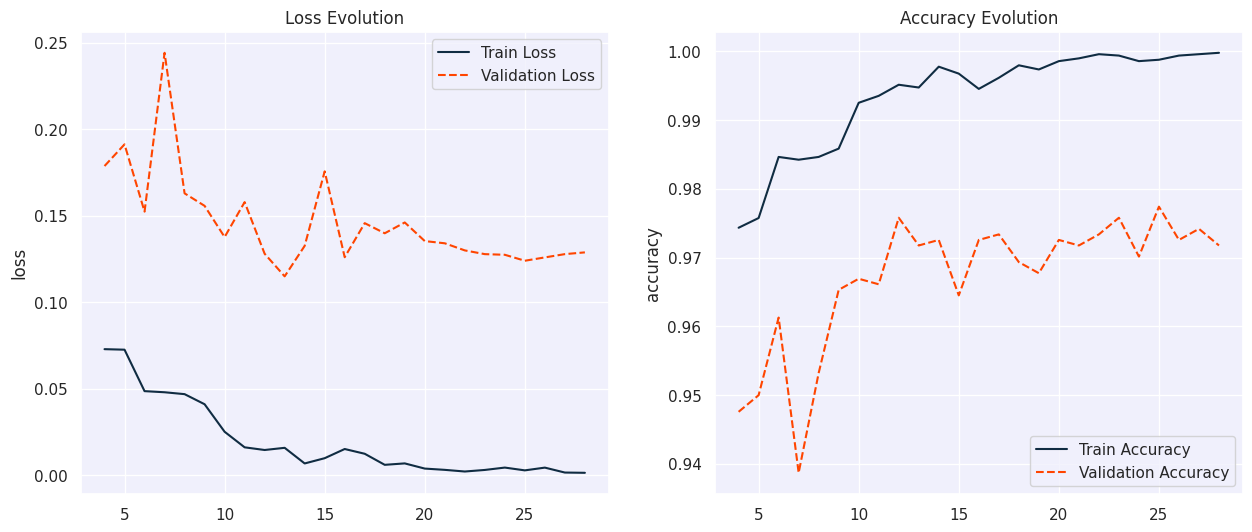

In [33]:
plot_learning_curves(history)

## 📊 Model Learning Curve Analysis
- From the learning curves, it's clear that the training loss is decreasing and leveling out, which is a good sign that the model is learning effectively from the training data. The training accuracy is high and stable, indicating strong performance on the training set. The validation accuracy is slightly lower than the training accuracy but remains relatively high, which means the model is performing well on unseen data too. Overall, the model seems to be performing well.

In [ ]:
# this is not Overfitting because Overfitting happens when the performance of the model on the Training Data is much better than the performance of the model on the validation data
# but if the performance of the model on the Training Data is much better than the performance of the model on the validation data this is means an Overfitting

### Step 6.2 | Performance Metrics Assessment

Now, we're set to assess the model's performance on the validation set, focusing on key metrics. I'll explore accuracy, precision, recall, and F1-score for a well-rounded understanding of how effectively the model classifies brain MRI images. Additionally, a confusion matrix will provide valuable insights into the model's prediction accuracy for each class, helping us identify any specific areas for improvement:

In [36]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes
    # val_generator.classes contains the true class indices (e.g., 0, 1, 2, 3) for all validation images.
    # Example: [0, 1, 2, 0, 3, 1]

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())
    # val_generator.class_indices is a dictionary mapping class names to indices:
    # {'no_tumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}
    # .keys() gives the class names → ['no_tumor', 'glioma', 'meningioma', 'pituitary']

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    # model.predict gives probabilities for each class for every validation image.
    # Shape = (num_validation_images, num_classes)
    # Example for 5 validation images and 4 classes:
    #  [
    #  [0.1, 0.7, 0.1, 0.1],   # Image 1 → 70% glioma
    #  [0.9, 0.05, 0.03, 0.02], # Image 2 → 90% no_tumor
    #  [0.2, 0.1, 0.6, 0.1],   # Image 3 → 60% meningioma
    #  [0.8, 0.1, 0.05, 0.05], # Image 4 → 80% no_tumor
    #  [0.05, 0.05, 0.1, 0.8]  # Image 5 → 80% pituitary
    # ]

    # val_generator is a batch generator.
        # It loads 32 images at a time (if batch_size=32).
        # Each time you call it, it gives you the next batch.
    
    # So setting steps=len(val_generator) means:
        # Process ALL batches in the validation set.
        # Which means process ALL validation images.
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    # np.argmax finds the index of the highest probability (i.e., the predicted class) for each validation Image .
    # For the example above:[1, 0, 2, 0, 3]

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.95      0.96       360
meningioma_tumor       0.96      0.96      0.96       366
          normal       0.99      0.99      0.99       176
 pituitary_tumor       0.98      0.99      0.99       338

        accuracy                           0.97      1240
       macro avg       0.97      0.97      0.97      1240
    weighted avg       0.97      0.97      0.97      1240





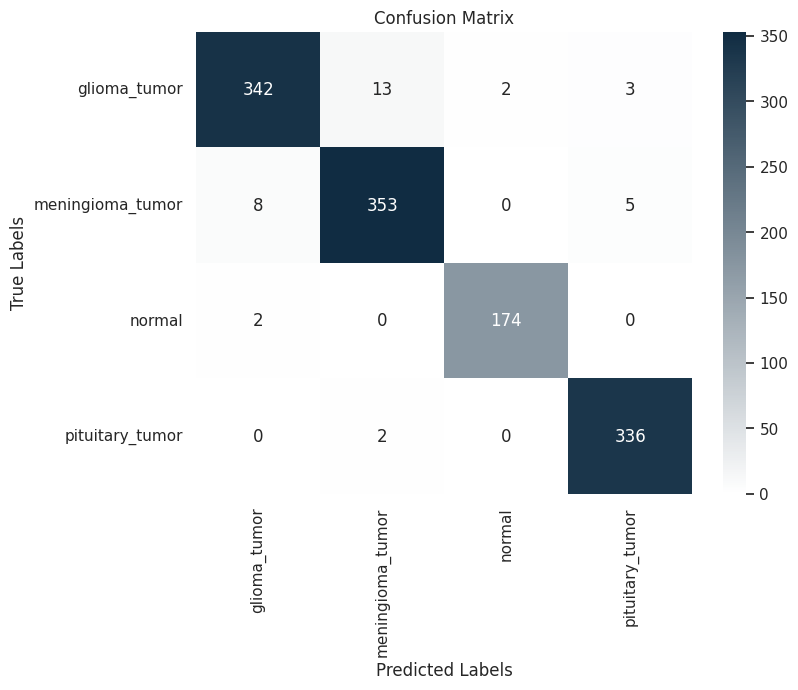

In [37]:
evaluate_model_performance(model, val_generator, classes)
# 39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step ==> this means we have 39 batches of validation Images 
# yeb2a el model 3aml predict l kol el batches ely mawgooda fy el validation Images aw 3aml predict l kol el validation Images ely mawgooda 3shan steps=len(val_generator) ely mawgooda fy el cell ely foo2

### 📈 Model Validation Performance Review
- The model's validation performance is impressive. The confusion matrix shows that it can distinguish between the different tumor types with high accuracy, rarely confusing one type for another. The classification report further illustrates this with high precision and recall across all classes, indicating both a low number of false positives and false negatives. Specifically, the model is exceptionally precise in identifying 'normal' cases without tumors. Overall, the high F1-scores across all categories reflect a well-balanced model that performs consistently across the board.

## Step 7 | Saving the Model for Deployment

- In this final step, I am securing our hard work by saving the fully trained ResNet50V2 model. This includes both the model's weights and its architecture, ensuring we can deploy it effectively in a Web Application. I'll use a function to zip and download it, making it easily accessible for future use and deployment:

In [38]:
# Save the entire ResNet50V2 model
model.save('ResNet50V2_model.h5') # you can rename it with any name you want like brain_tumor_model.h5

In [39]:
def download_all_models(files, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    
    # Create a command to zip all files
    command = f"zip {zip_name} " + " ".join(files)
    
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    
    display(FileLink(f'{download_file_name}.zip'))

In [40]:
# List of model files to download
model_files = ['ResNet50V2_model.h5']

# Call the function with the list of files 
download_all_models(model_files, 'model_archive')

/kaggle/working/model_archive.zip